In [1]:
import os
import cmdstanpy as stan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import multiprocessing
import pickle
import arviz as az
from scipy.special import expit

In [2]:
%load_ext stanmagic

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set() 

# Toy model

## Data

[]

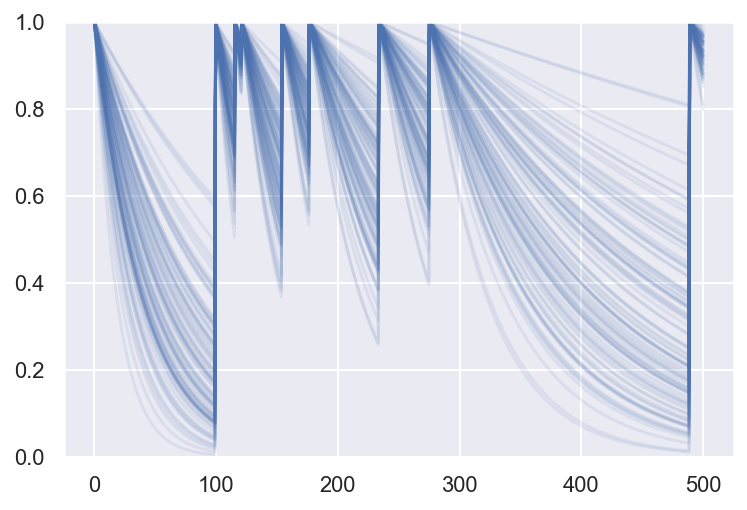

In [4]:
theta1 = np.random.normal(-4, 0.5, size=100)
theta2 = np.random.normal(-2, 0.4, size=100)

max_t = 5* 10**2
n_pres = 10

x = np.linspace(0, max_t, 1000)
pres = np.concatenate(([0,], np.sort(np.random.uniform(0, max_t, n_pres-1))))

n = np.zeros(x.shape)

delta = np.zeros(x.shape)
for i, p in enumerate(pres):
    delta[x>p] = x[x>p] - p
    n[x>p] = i
fig, ax = plt.subplots()

for th1, th2 in zip(theta1, theta2):
    alpha, beta = np.exp(th1), expit(th2)
    # print("alpha-beta", alpha, beta)
    p = np.exp(-alpha*(1-beta)**n*delta)
    ax.plot(x, p, color='C0', alpha=0.1)
ax.set_ylim(0, 1)
plt.plot()

In [5]:
# Seed
np.random.seed(123)


sg_u = 0.1, 0.1
sg_w = 0.5, 0.3

sg_theta = (0.001, 0.001)

mu = (-4, 0.3)
n_param = 2

# Number of users
n_u = 20
# Number of words
n_w = 10
# Number of obs
n_o = 10

t_max = 100

# Number of words seen by a single user
n_w_by_u = np.random.randint(3, 5, n_u)
n_o_by_u = np.random.randint(n_o-2, n_o, n_u)

U = np.random.normal(0, sg_u, size=(n_u, n_param))   # User ability
W = np.random.normal(0, sg_w, size=(n_w, n_param))   # Item difficulty
rd = np.random.normal(size=(n_u, n_o))

words = np.zeros(shape=(n_u, n_o), dtype=int)
delta = np.random.uniform(0, t_max, size=(n_u, n_o))
n_rep = np.zeros(shape=(n_u, n_o), dtype=int)
y = np.zeros(shape=(n_u, n_o), dtype=int)

for u in range(n_u):
    n_wu = n_w_by_u[u]
    n_ou = n_o_by_u[u]
    seen = np.random.choice(np.arange(n_w), replace=False, size=n_wu)
    words_u = np.random.choice(seen, replace=True, size=n_ou)
    counts = {word: 0 for word in seen}
    for i, word in enumerate(words_u):
        n_rep[u, i] = counts[word]
        counts[word] += 1
    
    words[u, :n_ou] = words_u
    mu_u = mu + U[u] + W[words_u]
    theta = np.random.normal(mu_u, sg_theta)
    a = np.exp(theta[:, 0])
    b = expit(theta[:, 1])
    exponent = - a *(1-b)**n_rep[u, :n_ou] * delta[u, :n_ou]
    p = np.exp(exponent)
    y[u, :n_ou] = p > rd[u, :n_ou]

data = {'n_u': n_u, 'n_w': n_w,  'n_o': n_o, 'delta': delta, 'n_rep': n_rep, 'y': y,
        'n_o_by_u': n_o_by_u,
        'words': words+1} # Stan index starts from 1

In [6]:
print(np.mean(p), np.max(p), np.min(p))
print(np.mean(y), np.min(y), np.max(y))

0.7561073138435603 0.9890494504824527 0.4695620424719236
0.66 0 1


# Model

In [7]:
%%stan -f model2paramIncmp.stan -v model2paramIncmp --stanc ~/.cmdstan/cmdstan-2.26.1/bin/stanc
data {
  int<lower=0> n_u;    
  int<lower=0> n_w;  
  int<lower=0> n_o;  
  real delta[n_u, n_o];
  int n_rep[n_u, n_o];
  int y[n_u, n_o];
  int words[n_u, n_o];
  int n_o_by_u[n_u];
}
transformed data {
}
parameters {
  real<lower=0> sg_u1;
  real<lower=0> sg_w1;
  real<lower=0> sg_theta1;
  real mu1;
  real<lower=0> sg_u2;
  real<lower=0> sg_w2;
  real<lower=0> sg_theta2;
  real mu2;
  
  real U1[n_u];
  real W1[n_w];
  real theta1_wu[n_u, n_o];
  real U2[n_u];
  real W2[n_w];
  real theta2_wu[n_u, n_o];
}
model {
  int n_ou;
  real eps;
  
  vector[n_o] a;
  vector[n_o] b;
  vector[n_o] rate;
  vector[n_o] exponent;
  vector[n_o] p;
  vector[n_o] p_suc;
  vector[n_o] log_p;
  vector[n_o] y_arr;
  vector[n_o] delta_arr;
  vector[n_o] n_rep_arr;
  vector[n_o] mu1_u;
  vector[n_o] mu2_u;
  int words_u[n_o];
  
  eps = machine_precision();
  
  sg_w1 ~ inv_gamma(1, 1);
  sg_u1 ~ inv_gamma(1, 1);
  sg_theta1 ~ inv_gamma(1, 1);
  mu1 ~ normal(0, 10);
  U1 ~ normal(0, sg_u1);
  W1 ~ normal(0, sg_w1);
  
  sg_w2 ~ inv_gamma(1, 1);
  sg_u2 ~ inv_gamma(1, 1);
  sg_theta2 ~ inv_gamma(1, 1);
  mu2 ~ normal(0, 10);
  U2 ~ normal(0, sg_u2);
  W2 ~ normal(0, sg_w2);

  for (u in 1:n_u) {
    n_ou = n_o_by_u[u];
    words_u[1:n_ou] = words[u, 1:n_ou];
    mu1_u[1:n_ou] = rep_vector(mu1 + U1[u], n_ou) + to_vector(W1[words_u[1:n_ou]]);
    mu2_u[1:n_ou] = rep_vector(mu2 + U2[u], n_ou) + to_vector(W2[words_u[1:n_ou]]);
    theta1_wu[u, 1:n_ou] ~ normal(mu1_u[1:n_ou], sg_theta1);
    theta2_wu[u, 1:n_ou] ~ normal(mu2_u[1:n_ou], sg_theta2);
    a[1:n_ou] = exp(to_vector(theta1_wu[u, 1:n_ou]));
    b[1:n_ou] = inv_logit(to_vector(theta2_wu[u, 1:n_ou]));
    n_rep_arr[1:n_ou] = to_vector(n_rep[u, 1:n_ou]);
    delta_arr[1:n_ou] = to_vector(delta[u, 1:n_ou]);
    y_arr[1:n_ou] = to_vector(y[u, 1:n_ou]);
    exponent[1:n_ou] = - a[1:n_ou] .* pow(1-b[1:n_ou], n_rep_arr[1:n_ou]) .* delta_arr[1:n_ou];
    p_suc[1:n_ou] = exp(exponent[1:n_ou]);
    p[1:n_ou] = pow(p_suc[1:n_ou], y_arr[1:n_ou]) .* pow(1-p_suc[1:n_ou], 1-y_arr[1:n_ou]);
    log_p[1:n_ou] = log(p[1:n_ou]+eps);
    target += sum(log_p[1:n_ou]);
  }
}

Using stanc compiler:  ~/.cmdstan/cmdstan-2.26.1/bin/stanc
~/.cmdstan/cmdstan-2.26.1/bin/stanc --o=/var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/9b1b4d35-72bf-427b-b1c3-6bd6ad71455e.cpp model2paramIncmp.stan

-------------------------------------------------------------------------------
Model compiled successfully. Output stored in model2paramIncmp object.
Type model2paramIncmp in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^^^^^^^
Access model compile output properties
model2paramIncmp.model_file -> Name of stan_file [model2paramIncmp.stan]
model2paramIncmp.model_name -> Name of stan model [model2paramIncmp_model]
model2paramIncmp.model_code -> Model code [data {   int<lower=0 ....]


In [9]:
%%time
m = stan.CmdStanModel(stan_file=model2paramIncmp.model_file)

INFO:cmdstanpy:compiling stan program, exe file: /Users/aureliennioche/Documents/PythonProjects/ActiveTeachingCollaborative/model2paramIncmp
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/aureliennioche/Documents/PythonProjects/ActiveTeachingCollaborative/model2paramIncmp


CPU times: user 4.76 ms, sys: 7.28 ms, total: 12 ms
Wall time: 23.2 s


In [10]:
%%time
trace = m.sample(data=data, show_progress="notebook")

Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 4 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 420 ms, sys: 88.4 ms, total: 508 ms
Wall time: 5min 23s


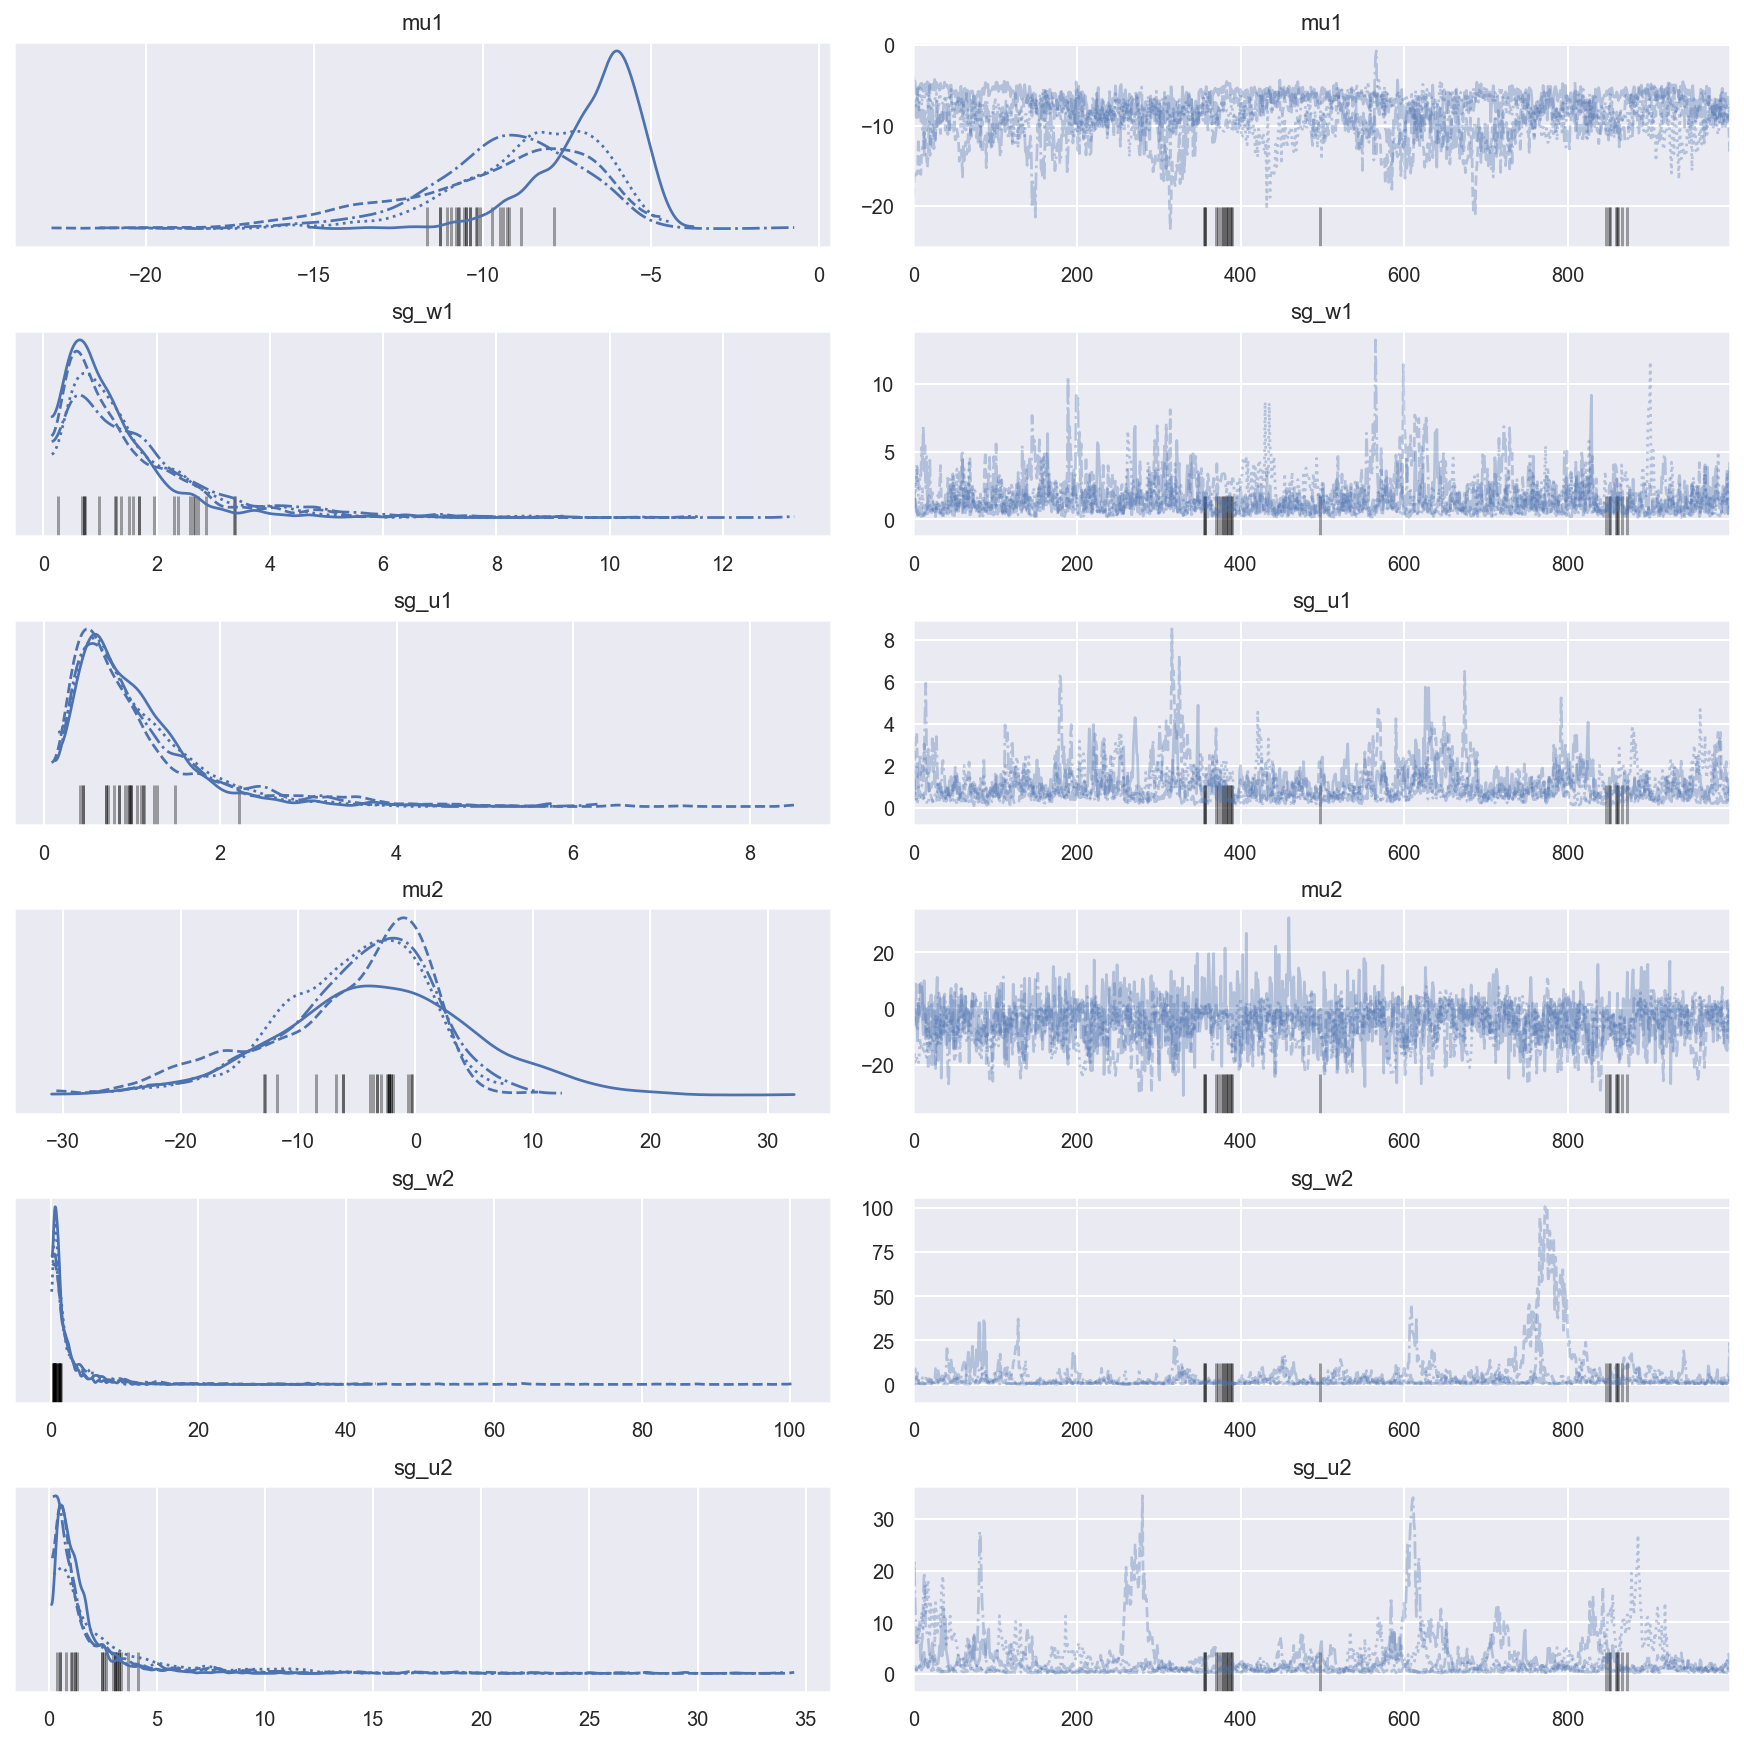

In [11]:
az.plot_trace(trace, var_names=['mu1', 'sg_w1', 'sg_u1', 'mu2', 'sg_w2', 'sg_u2']);

## MLE

In [69]:
%%time
mp = m.optimize(data=data, algorithm='BFGS', seed=1)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


CPU times: user 8.11 ms, sys: 8.54 ms, total: 16.7 ms
Wall time: 18.6 s


In [62]:
for var in 'mu1', 'sg_w1', 'sg_u1', 'mu2', 'sg_w2', 'sg_u2':
    print(var, mp.optimized_params_dict[var])

mu1 -5.00154
sg_w1 0.086145
sg_u1 0.045624
mu2 -1.32281
sg_w2 0.083496
sg_u2 0.0454663
